### PROBLEM STATEMENT:
For the final assignment of this proejct, you need to design and implement an effective trading strategy using a combination of a technical indicator and a chart pattern or candlestick pattern. The objective is to optimize the strategy based on the evaluation criteria of cumulative returns, maximum drawdown, and Sharpe ratio. Along with Jupyter notebook, submit a doc explaining the approach taken to combine these indicators and patterns. You should also provide a logical explanation regarding any limitations in detecting specific price trends. Any additional enhancements to the strategy are encouraged and should be included. The strategy must be tested on a 10 year period, ending on the submission day, using any chosen Indian equity. The document should include the values of the three metrics mentioned and can also discuss other combinations or logics that were explored before finalizing the strategy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.simplefilter('ignore')

In [2]:
equity = "HDFCBANK.NS"  # SBI Bank
start_date = "2013-07-06"
end_date = "2023-07-06"
equity_data = yf.download(equity, start=start_date, end=end_date, progress=False)

In [3]:
equity_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2464 entries, 2013-07-08 to 2023-07-05
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2464 non-null   float64
 1   High       2464 non-null   float64
 2   Low        2464 non-null   float64
 3   Close      2464 non-null   float64
 4   Adj Close  2464 non-null   float64
 5   Volume     2464 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 134.8 KB


In [4]:
equity_data.head(10)

Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-07-08  332.000000  333.725006  326.375000  330.225006  307.046478   
2013-07-09  331.100006  336.875000  331.100006  335.149994  311.625793   
2013-07-10  335.125000  335.950012  328.075012  329.649994  306.511780   
2013-07-11  333.500000  343.350006  333.024994  341.625000  317.646271   
2013-07-12  343.500000  348.850006  340.899994  347.875000  323.457642   
2013-07-15  345.500000  349.024994  342.000000  347.725006  323.318115   
2013-07-16  339.500000  342.250000  334.975006  339.350006  315.531006   
2013-07-17  338.899994  340.399994  323.950012  331.450012  308.185547   
2013-07-18  334.950012  344.250000  328.475006  342.049988  318.041412   
2013-07-19  344.024994  345.975006  336.575012  340.000000  316.135376   

              Volume  
Date                  
2013-07-08   3584648  
2013-07-09   3520096  
2013-07-10   3569290  
2013-07-11   5299784  
2013-07-12   7817426  
2013-07-15   4255944  
2013-07-16   5823692  
2013-07-17  11316994  
2013-07-18   6831940  
2013-07-19   6229210

In [5]:
equity_data.describe()

Open         High          Low        Close    Adj Close  \
count  2464.000000  2464.000000  2464.000000  2464.000000  2464.000000   
mean    959.056940   967.824887   949.608696   958.895871   928.521911   
std     422.772412   426.529529   418.854607   422.653283   422.570735   
min     277.850006   286.000000   264.000000   280.950012   261.230072   
25%     539.250000   543.437500   534.250000   539.850021   508.957428   
50%     974.975006   982.924988   963.700012   974.125000   938.028687   
75%    1359.925018  1371.487488  1343.949982  1356.062500  1334.893646   
max    1723.449951  1757.500000  1713.800049  1728.199951  1728.199951   

             Volume  
count  2.464000e+03  
mean   6.521975e+06  
std    6.777056e+06  
min    0.000000e+00  
25%    2.813840e+06  
50%    4.792492e+06  
75%    7.903996e+06  
max    2.011300e+08

### CODING THE KELTNER CHANNEL: 

The Keltner Channel is a technical analysis indicator that consists of an exponential moving average (EMA) and two bands, an upper band and a lower band. The bands are calculated by adding and subtracting a multiple of the average true range (ATR) from the EMA. This function takes in a DataFrame containing the necessary data columns ('Close', 'High', 'Low'), and calculates the Keltner Channel bands using the specified parameters.The Exponential Moving Average (EMA) is calculated using the 'Close' column with the specified EMA period.

The Average True Range (ATR) is calculated using the 'High', 'Low', and 'Close' columns. The high-low range and the absolute differences between the high and the previous close, and the low and the previous close are computed. The maximum of these values is taken as the true range, and the ATR is calculated by taking the rolling mean of the true range over the specified ATR period.

The upper and lower bands of the Keltner Channel are calculated by adding and subtracting a multiple of the ATR from the EMA. The function returns the EMA values, as well as the upper and lower Keltner Channel band values as Series.





In [6]:
def calculate_keltner_channel_bands(data, ema_period=20, atr_period=10, multiplier=2):
    
    """
    Calculate the upper and lower bands of the Keltner Channel based on the given data.

    Args:
        data (pandas.DataFrame): Dataframe containing the necessary columns 'Close', 'High', and 'Low'.
        ema_period (int): Period for the Exponential Moving Average (EMA) calculation. Default is 20.
        atr_period (int): Period for the Average True Range (ATR) calculation. Default is 10.
        multiplier (float): Multiplier for calculating the distance between the bands and the EMA. Default is 2.

    Returns:
        tuple: A tuple containing three pandas.Series objects representing the EMA, upper band, and lower band, respectively.
    """
    
    # Exponential Moving Average (EMA)
    ema = data['Close'].ewm(span=ema_period, adjust=False).mean()

    #Average True Range (ATR)
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(atr_period).mean()

    #Keltner Channel
    upper_band = ema + (multiplier * atr)
    lower_band = ema - (multiplier * atr)

    return ema, upper_band, lower_band


In [7]:
#Keltner Channel figure for each year
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

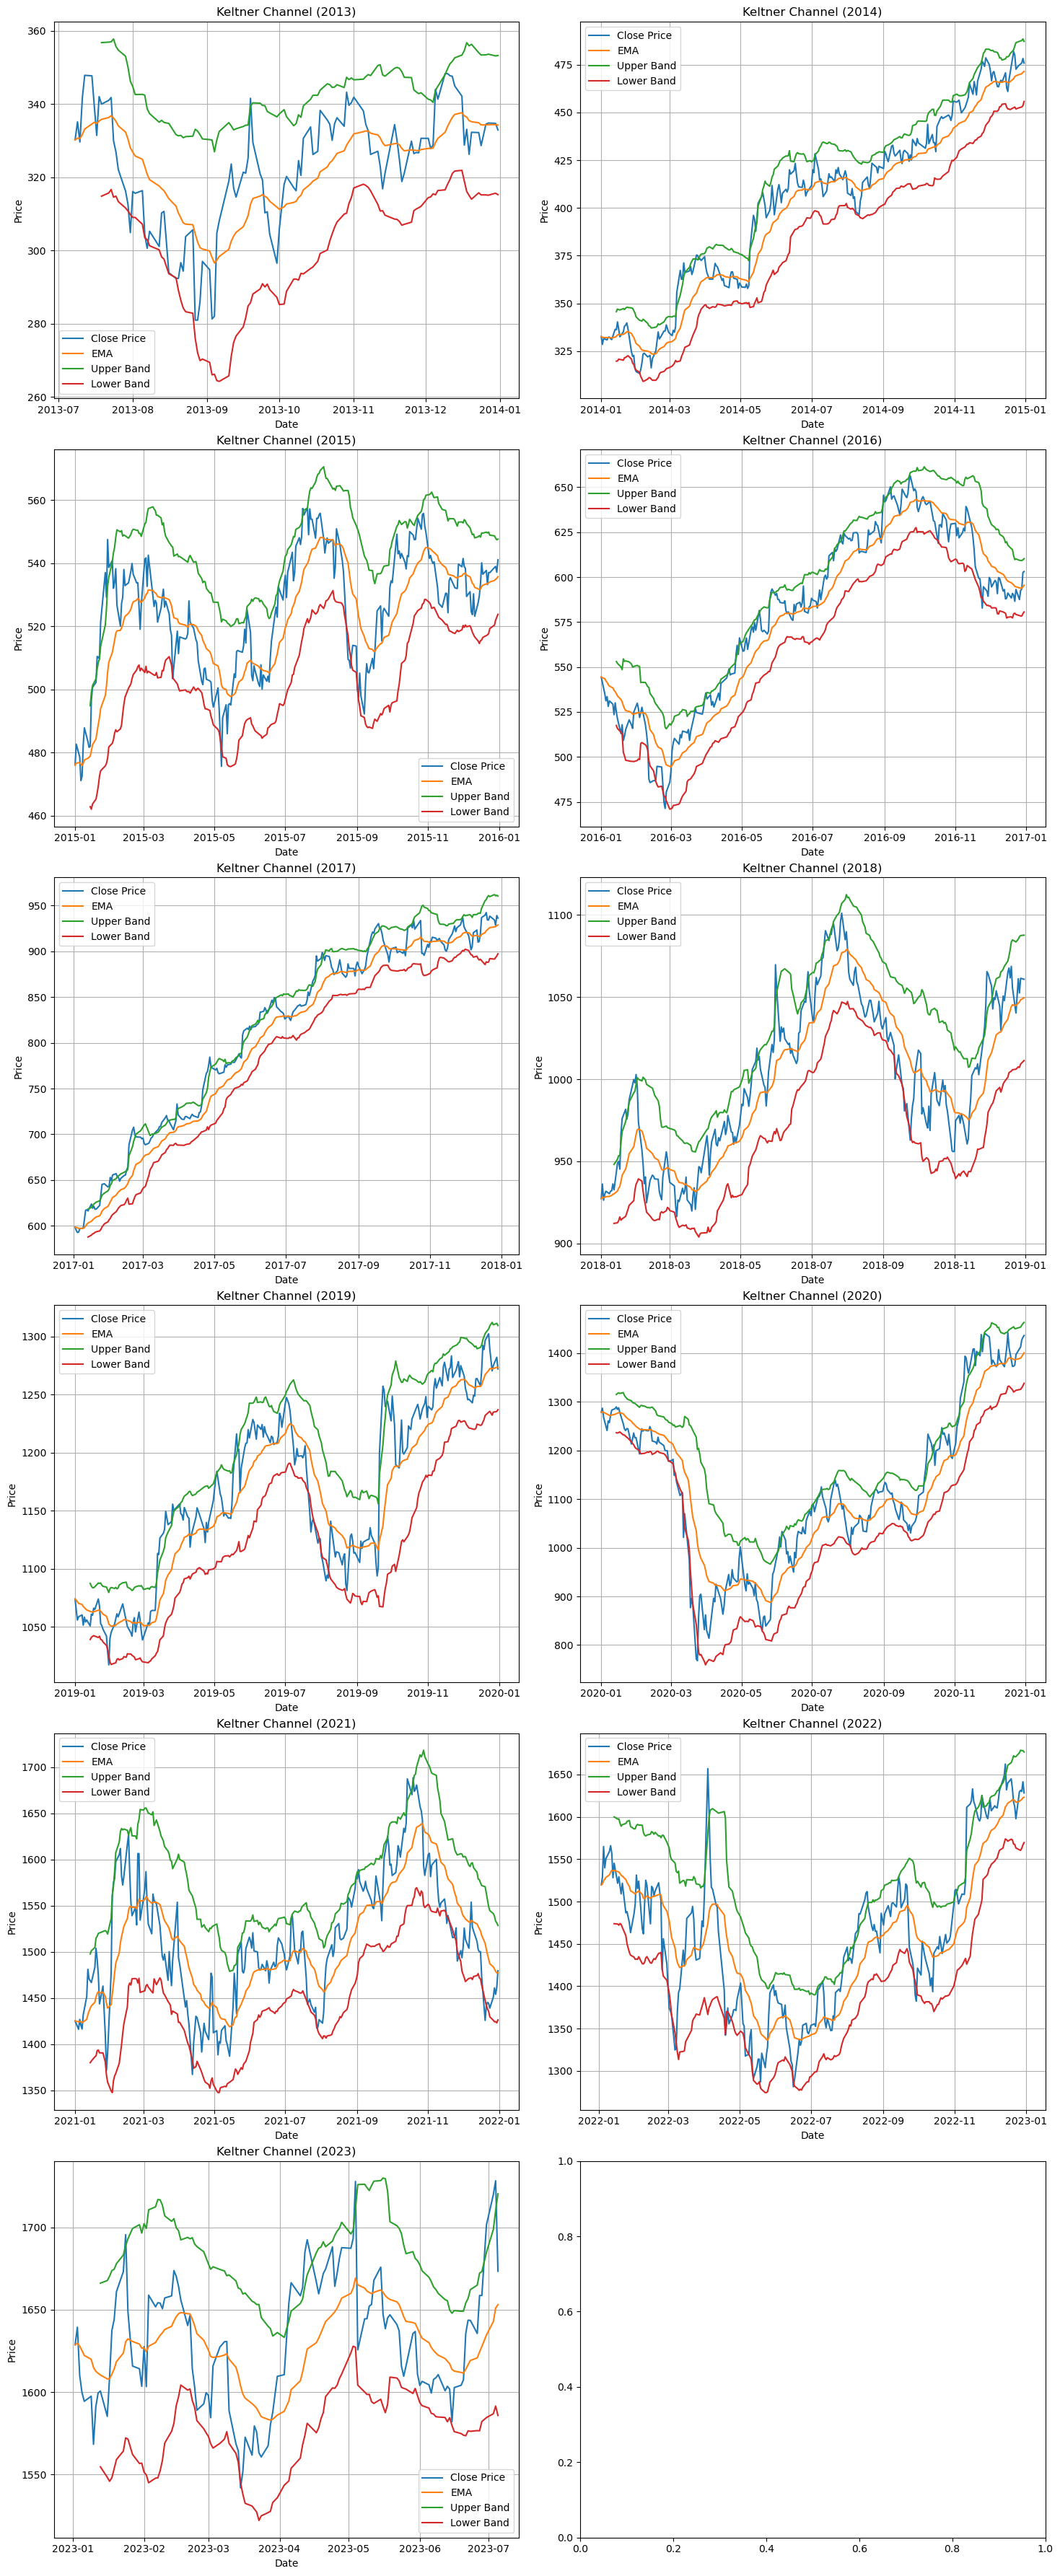

In [8]:
start_year = start_date.year
end_year = end_date.year
total_years = end_year - start_year + 1

# Calculate the number of rows and columns for the subplot grid
num_rows = (total_years + 1) // 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
fig.tight_layout(pad=3.0)

for i, year in enumerate(range(start_year, end_year + 1)):
    year_data = equity_data[str(year)]
    ema, upper_band, lower_band = calculate_keltner_channel_bands(year_data)

    # Calculate subplot position
    row = i // num_cols
    col = i % num_cols

    # Plotting
    axs[row, col].plot(year_data.index, year_data['Close'], label='Close Price')
    axs[row, col].plot(year_data.index, ema, label='EMA')
    axs[row, col].plot(year_data.index, upper_band, label='Upper Band')
    axs[row, col].plot(year_data.index, lower_band, label='Lower Band')
    axs[row, col].set_title('Keltner Channel ({0})'.format(year))
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Price')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.show()

The graph graph can be explained as when the closing price consistently reaches or exceeds the upper band, it may suggest an overbought condition, indicating a potential reversal or correction. Conversely, when the closing price consistently falls below the lower band, it may indicate an oversold condition, signaling a potential bounce or upward move.

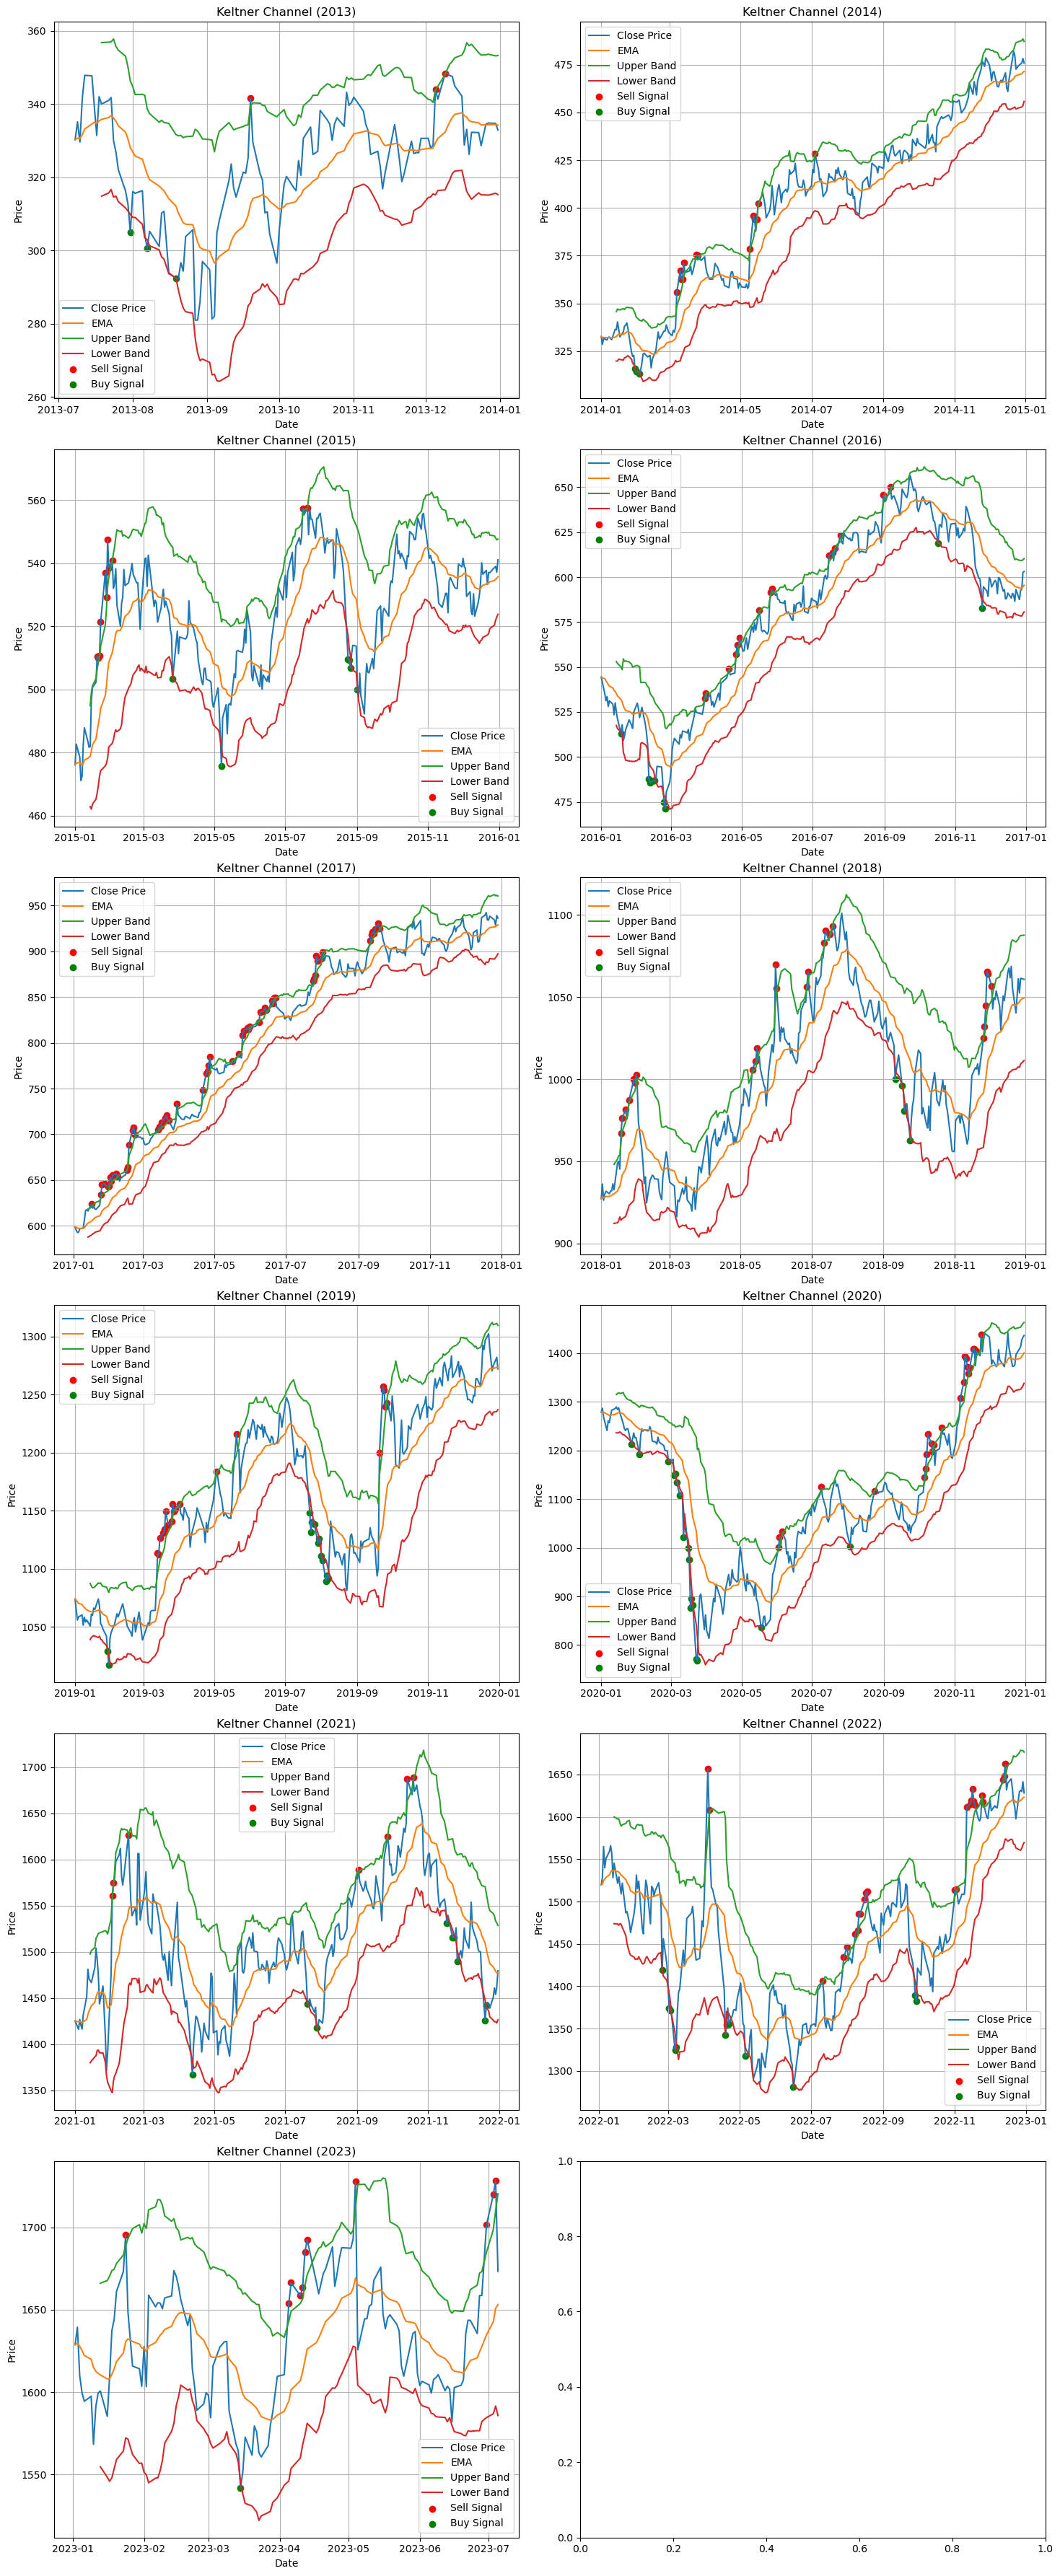

In [9]:
start_year = start_date.year
end_year = end_date.year
total_years = end_year - start_year + 1

# Calculate the number of rows and columns for the subplot grid
num_rows = (total_years + 1) // 2
num_cols = 2

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 6*num_rows))
fig.tight_layout(pad=3.0)

for i, year in enumerate(range(start_year, end_year + 1)):
    year_data = equity_data[str(year)]
    ema, upper_band, lower_band = calculate_keltner_channel_bands(year_data)

    # Here we are generating sell and buy signals
    sell_signals = year_data[year_data['Close'] > upper_band]['Close']
    buy_signals = year_data[year_data['Close'] < lower_band]['Close']

    # Calculate subplot position
    row = i // num_cols
    col = i % num_cols

    # Plotting
    axs[row, col].plot(year_data.index, year_data['Close'], label='Close Price')
    axs[row, col].plot(year_data.index, ema, label='EMA')
    axs[row, col].plot(year_data.index, upper_band, label='Upper Band')
    axs[row, col].plot(year_data.index, lower_band, label='Lower Band')
    axs[row, col].scatter(sell_signals.index, sell_signals, color='red', label='Sell Signal', marker='o')
    axs[row, col].scatter(buy_signals.index, buy_signals, color='green', label='Buy Signal', marker='o')
    axs[row, col].set_title('Keltner Channel ({0})'.format(year))
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Price')
    axs[row, col].legend()
    axs[row, col].grid(True)

plt.show()

### Trading Strategy:
* If the price is below the lower line of the Keltner Channel, it indicates a potential buying opportunity.
* If the price is above the upper line of the Keltner Channel, it suggests a potential selling opportunity.

In [10]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [11]:
start_year = start_date.year
end_year = end_date.year
total_years = end_year - start_year + 1

# Calculate the number of rows and columns for the subplot grid
num_rows = (total_years + 1) // 2
num_cols = 2

for i, year in enumerate(range(start_year, end_year + 1)):
    year_data = equity_data[str(year)]

    # Preparing data for candlestick plot
    candlestick = go.Candlestick(
        x=year_data.index,
        open=year_data['Open'],
        high=year_data['High'],
        low=year_data['Low'],
        close=year_data['Close']
    )

    # Calculate subplot position
    row = i // num_cols
    col = i % num_cols

    # Plotting
    layout = go.Layout(
        title='Candlestick Chart ({0})'.format(year),
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price'),
        showlegend=False
    )
    fig = go.Figure(data=[candlestick], layout=layout)
    fig.update_layout(height=400, width=1500)  # Set the desired chart size
    fig.show()

In [12]:
for year in range(start_date.year, end_date.year + 1):
    year_data = equity_data[str(year)]
    ema, upper_band, lower_band = calculate_keltner_channel_bands(year_data)

    # Here we are preparing data for candlestick plot
    candlestick = go.Candlestick(
        x=year_data.index,
        open=year_data['Open'],
        high=year_data['High'],
        low=year_data['Low'],
        close=year_data['Close']
    )

    #Here we are plotting
    fig = go.Figure()

    # Here we are adding candlestick trace
    fig.add_trace(candlestick)

    # Here we are adding Keltner Channel lines
    fig.add_trace(go.Scatter(
        x=year_data.index, y=ema,
        mode='lines',
        name='EMA',
        line=dict(color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=upper_band,
        mode='lines',
        name='Upper Band',
        line=dict(color='orange')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=lower_band,
        mode='lines',
        name='Lower Band',
        line=dict(color='orange')
    ))

    # Here we are setting layout
    fig.update_layout(
        title='Keltner Channel and Candlestick Chart ({0})'.format(year),
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price')
    )

    # Show the combined plot
    fig.show()

In [13]:
start_date = pd.to_datetime("2013-07-05")
end_date = pd.to_datetime("2023-07-05")

for year in range(start_date.year, end_date.year + 1):
    year_data = equity_data[str(year)]
    ema, upper_band, lower_band = calculate_keltner_channel_bands(year_data)

    # Here we are preparing data for candlestick plot
    candlestick = go.Candlestick(
        x=year_data.index,
        open=year_data['Open'],
        high=year_data['High'],
        low=year_data['Low'],
        close=year_data['Close']
    )

    # Here we are plotting
    fig = go.Figure()

    # Here we are adding candlestick trace
    fig.add_trace(candlestick)

    # Here we are adding Keltner Channel lines
    fig.add_trace(go.Scatter(
        x=year_data.index, y=ema,
        mode='lines',
        name='EMA',
        line=dict(color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=upper_band,
        mode='lines',
        name='Upper Band',
        line=dict(color='orange')
    ))
    fig.add_trace(go.Scatter(
        x=year_data.index, y=lower_band,
        mode='lines',
        name='Lower Band',
        line=dict(color='orange')
    ))

    # Here we are finding hammer candlestick pattern
    hammer_pattern = year_data[(year_data['Low'] - year_data['Open']) > 2 * (year_data['Close'] - year_data['Open'])]

    # Here we are generating buy and sell signals
    buy_signals = hammer_pattern['High'] + 0.01
    sell_signals = hammer_pattern['Low'] - 0.01

    # Here we are plotting buy signals
    fig.add_trace(go.Scatter(
        x=hammer_pattern.index,
        y=buy_signals,
        mode='markers',
        marker=dict(symbol="cross", color="green"),
        name='Buy Signals'
    ))

    # Here we are plotting sell signals
    fig.add_trace(go.Scatter(
        x=hammer_pattern.index,
        y=sell_signals,
        mode='markers',
        marker=dict(symbol="cross", color="red"),
        name='Sell Signals'
    ))

    # Here we are setting layout
    fig.update_layout(
        title='Keltner Channel and Candlestick Chart ({0})'.format(year),
        xaxis=dict(title='Date'),
        yaxis=dict(title='Price'),
        showlegend=True
    )

    fig.show()

### Finding relevant statistics for the strategy: 

In [14]:
cumulative_returns = []
max_drawdowns = []
sharpe_ratios = []

In [15]:
#Returns, Drawdown, and Sharpe Ratio
returns = (hammer_pattern['Close'].pct_change() + 1).cumprod()
cumulative_returns.append(returns[-1] - 1)

# Drawdown
equity_curve = returns.cumprod()
previous_peaks = equity_curve.cummax()
drawdowns = (equity_curve - previous_peaks) / previous_peaks
max_drawdowns.append(drawdowns.max())

# Sharpe Ratio
daily_returns = hammer_pattern['Close'].pct_change()
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
sharpe_ratios.append(sharpe_ratio)

In [16]:
mean_cumulative_returns = np.mean(cumulative_returns)
mean_max_drawdowns = np.mean(max_drawdowns)
mean_sharpe_ratios = np.mean(sharpe_ratios)

In [17]:
print("Mean Cumulative Returns: ", mean_cumulative_returns)
print("Mean Maximum Drawdowns: ", mean_max_drawdowns)
print("Mean Sharpe Ratios: ", mean_sharpe_ratios)

Mean Cumulative Returns:  0.03928449307898063
Mean Maximum Drawdowns:  0.0
Mean Sharpe Ratios:  0.9990693535502156
